# Data exploration

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append("..")

import torch
import torch.nn as nn
import numpy as np

import aggets.ds.moving as moving
import aggets.ds.aggregate3 as aggregate
import aggets.ds.hyper_f_load as hyper_f_load

from scipy.io import arff

In [2]:
path = './data/ts/hyperplane/hyper_f.csv'
data_test = pd.read_csv(path)

In [3]:
data_test

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,class
0,0.397174,0.347518,0.294057,0.506484,0.115967,0.770536,0.659893,0.156747,0.378202,0.139763,0
1,0.275030,0.075388,0.610592,0.954931,0.274069,0.190202,0.001299,0.683527,0.486260,0.487515,0
2,0.233156,0.889909,0.038327,0.592379,0.655174,0.119839,0.652477,0.984323,0.206738,0.374650,1
3,0.277937,0.340915,0.265790,0.116670,0.136830,0.546089,0.494619,0.015384,0.358995,0.242478,0
4,0.254909,0.777916,0.225022,0.983103,0.803619,0.836315,0.163104,0.637497,0.008760,0.631190,0
...,...,...,...,...,...,...,...,...,...,...,...
999995,0.998501,0.507983,0.751220,0.122945,0.582209,0.230258,0.417630,0.112357,0.863361,0.229976,0
999996,0.324837,0.920977,0.489746,0.637164,0.654715,0.457670,0.617665,0.378239,0.130823,0.021858,0
999997,0.388339,0.504116,0.899589,0.336088,0.758977,0.821157,0.563754,0.619972,0.938034,0.964131,1
999998,0.172347,0.683183,0.620007,0.649647,0.208711,0.425091,0.209693,0.165179,0.523398,0.227523,0


Train, Vali, Test data split

tbd

# loading the data

In [4]:
path = './data/ts/new/fin_adult.csv'
fin_adult = pd.read_csv(path, names = ['att' + str(i + 1) for i in range(65)] + ['class'])


In [5]:
'''
path = './data/ts/new/numbers.csv'
data_test = pd.read_csv(path, names = ['att' + str(i+1) for i in range(16)] + ['class'])
data_test

FEATURES_NUMBER = 10
ROW_AMOUNT = 1000000

random_data = np.random.random(size=(ROW_AMOUNT,FEATURES_NUMBER))
random_classes = np.random.randint(0, 2, size=(ROW_AMOUNT))
random_df = pd.DataFrame(random_data, columns=['att' + str(i+1) for i in range(FEATURES_NUMBER)])
random_df['class'] = pd.Series(random_classes.T)
'''

# train, vali, test data split

In [6]:
data_test = fin_adult

train_p, vali_p, test_p = .7, .2, .1
n = data_test.shape[0]

train_df, vali_df, test_df = data_test[:int(n*train_p)], data_test[int(n*train_p):int(n*(train_p+vali_p))], data_test[int(n*(train_p+vali_p)):]

num_features = data_test.shape[1]
column_indices = {name: i for i, name in enumerate(data_test.columns)}

data_obj = {'train': train_df, 'val': vali_df, 'test': test_df, 'features': num_features, 'column_indices': column_indices , 'df': data_test}


# window generator

In [7]:
data = data_obj

wg = aggregate.WindowGenerator(chunk_size=500, samples=5, sample_frac=0.8, 
                               input_sequence_length=10,
                               df =  data['df'], # full columns information
                               train_df = data['train'],
                               val_df = data['val'],
                               test_df = data['test'],
                               label_columns=['class'],
                               bin_count=1, discretization=20)

wg_tmp = aggregate.WindowGenerator(chunk_size=500, samples=5, sample_frac=0.8, 
                               input_sequence_length=10,
                               df =  data['df'], # full columns information
                               train_df = data['train'],
                               val_df = data['val'],
                               test_df = data['test'],
                               label_columns=['class'],
                               bin_count=1, discretization=20)

In [8]:
wg.init_structures()

In [9]:
import aggets.util as util

util.save(wg, path='window_08_test.bin') # chunk_size=2500, samples=25, sample_frac=0.8, bin_count=1, discretization=20 (lr trains on data without bins), no normalization of aggregates, density included
wg_tmp.load_data(util.load(path='window_08_test.bin'))

In [10]:
wg_tmp.density = True
wg_tmp.density_encoded = True
wg_tmp.one_row_ts = True

wg_tmp.reverse_train = True
wg_tmp.shuffle_input = False
wg_tmp.shuffle_output = False
wg_tmp.double_target = False
wg_tmp.train_histograms = False

dim_p = wg_tmp.test_agges.shape[-1]
dim_d = wg_tmp.test_agges.shape[-1]
dim_lr = wg_tmp.test_lr.shape[-1]

print(dim_p, dim_d, dim_lr, wg_tmp.val_lr.shape)

223 223 66 torch.Size([19, 5, 66])


In [11]:
def plot(set_type, model, wg, axs, ylim=None):
    rolling = 300 if set_type == 'train' else 100
    aucs = wg.plot(model=model, model_data_fn=None, last_train=False, lr0=False, lr_t0=True,  # set_type=='train',
                   set_type=set_type, no_lr=False, model_resid=False, rolling=rolling, axs=axs,
                   plot_box_auc=False, lr_tn=10, train=0.5)

    vals = {}
    for key in aucs:
        if '=' in key:
            into = key[key.index('=') - 1:]
        else:
            into = key
        arr = vals.get(into, [])
        arr.append(np.mean(aucs[key].to_numpy()))
        vals[into] = arr
    if ylim is not None:
        plt.ylim(*ylim)
    plt.sca(axs[-1])
    plt.boxplot(list(vals.values()), showfliers=True)
    plt.xticks(range(1, len(vals.keys()) + 1), vals.keys(), rotation=90)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.ylabel('AUC')

config in=10, out=5
training model lstm
saving model MTL=2.8865781332218075e+24, MVL=2.0936162450646152e+24
saving model MTL=2.924428368193406e+24, MVL=2.093615956834239e+24


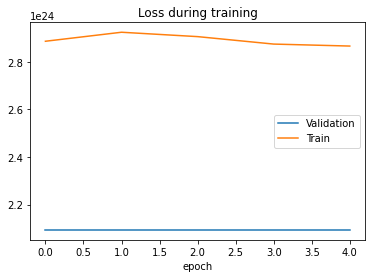

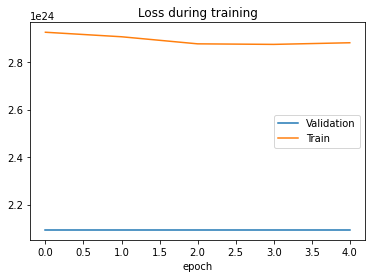

ZeroDivisionError: integer division or modulo by zero

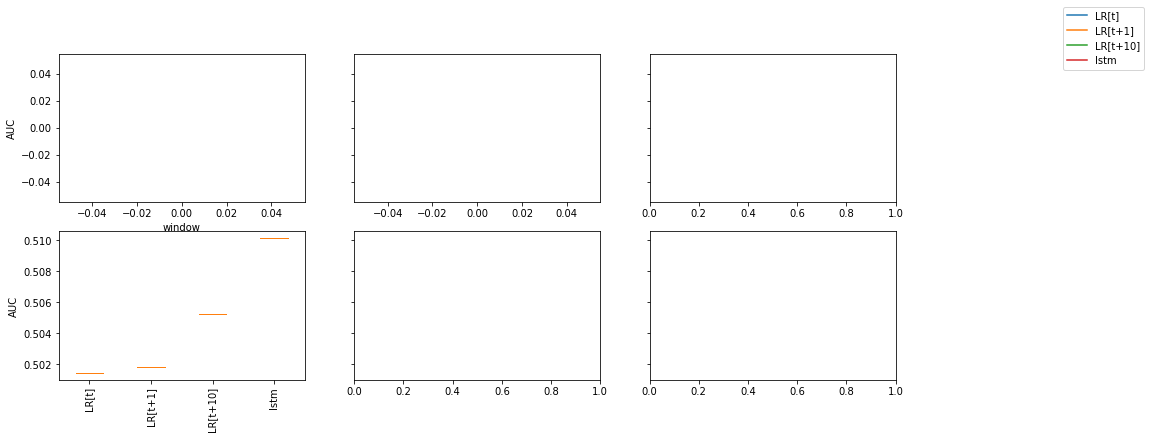

In [12]:
import aggets.model.aggregate as m_agg
import aggets.train as train


#
wg_tmp.input_sequence_length = 10

model = m_agg.AutoregLstmLr(dim_p + dim_d, dim_lr, num_layers=2, hidden=128,
                            output_sequence_length=5, return_deltas=False)
model.name=f'lstm'
train.train_window_models([model], wg_tmp, patience=5, validate=True, weight_decay=0, max_epochs=5,
                          lrs=[0.001, 0.0001])
model.window_config.output_sequence_length = 1
model.return_deltas = False

# przyjmuje wiecej niz jeden model
def plot_only(models, wg, ylim=None):
    _, axs = plt.subplots(ncols=3, nrows=2, sharey='row', figsize=(15,6))
    plot('train', models, wg, axs=[axs[0][0], axs[1][0]], ylim=ylim)
    plot('val',   models, wg, axs=[axs[0][1], axs[1][1]], ylim=ylim)
    plot('test',  models, wg, axs=[axs[0][2], axs[1][2]], ylim=ylim)
plot_only([model], wg_tmp)